# Solution Optimization Analysis

In [33]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## Load Datasets

In [34]:
raw_textgrad = pd.read_csv("results/raw_textgrad.csv")
raw_textgrad

,id,raw_solution,correct_answer,source,subject,solution_1,solution_2,solution_3,solution_4,solution_5
0,2,Here's how we can determine the number of carb...,A,GPQA-Diamond,-,Here's how we can determine the number of carb...,Here's how we can determine the number of carb...,Here's how we can determine the number of carb...,Here's how we can determine the number of carb...,Here's how we can determine the number of carb...
1,4,Maxwell's equations in our universe are:\n\n1....,A,GPQA-Diamond,-,Maxwell's equations in our universe are:\n\n1....,Maxwell's equations in our universe are:\n\n1....,"If magnetic monopoles exist, Gauss's law for m...","If magnetic monopoles exist, Gauss's law for m...","If magnetic monopoles exist, Gauss's law for m..."
2,8,Here's how we can analyze the results and dete...,B,GPQA-Diamond,-,Here's how we can analyze the results and dete...,Here's how we can analyze the results and dete...,"1. **G2's Essential Role:** The g2 mutant, and...","1. **G2's Essential Role:** The g2 mutant, and...","1. **G2's Essential Role:** The g2 mutant, and..."
3,42,Here's how we can solve this problem:\n\n1. **...,D,GPQA-Diamond,-,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...
4,36,Here's how we can determine the most likely ob...,C,GPQA-Diamond,-,Here's how we can determine the most likely ob...,Here's how we can determine the most likely ob...,Here's how we can determine the most likely ob...,Here's how we can determine the most likely ob...,Here's how we can determine the most likely ob...
...,...,...,...,...,...,...,...,...,...,...
407,404,The diffraction of electrons by a crystal latt...,A,MMLU-CP,college_physics,The diffraction of electrons by a crystal latt...,The diffraction of electrons by a crystal latt...,The diffraction of electrons by a crystal latt...,The diffraction of electrons by a crystal latt...,The diffraction of electrons by a crystal latt...
408,391,We can use Wien's displacement law to solve th...,B,MMLU-CP,college_physics,We can use Wien's displacement law to solve th...,We can use Wien's displacement law to solve th...,We can use Wien's displacement law to solve th...,We use Wien's displacement law to solve this p...,We use Wien's displacement law to solve this p...
409,384,Here's how we can solve this problem:\n\n1. **...,A,MMLU-CP,college_physics,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...
410,390,Here's how we can solve this problem:\n\n1. **...,D,MMLU-CP,college_physics,Here's how we can solve this problem:\n\n1. **...,Here's a revised solution:\n\n1. **Define the ...,Here's a revised solution:\n\n1. **Define the ...,Here's a corrected solution:\n\n1. **Define th...,Here's a corrected solution:\n\n1. **Define th...


In [35]:
tv_textgrad = pd.read_csv("results/tv_textgrad.csv")
tv_textgrad

,id,raw_solution,correct_answer,source,subject,solution_1,solution_2,solution_3,solution_4,solution_5
0,8,Here's how we can analyze the results and dete...,B,GPQA-Diamond,-,Here's how we can analyze the results:\n\n1. *...,"Let's analyze the data systematically, conside...","Let's analyze the data, explicitly defining a ...","Let's analyze the data, defining a baseline re...","Let's analyze the data, starting with a baseli..."
1,4,Maxwell's equations in our universe are:\n\n1....,A,GPQA-Diamond,-,"In our universe, Maxwell's equations are:\n\n1...",The presence of magnetic monopoles introduces ...,"In a universe with magnetic monopoles, Maxwell...",Here's a step-by-step analysis of how Maxwell'...,"In a universe with magnetic monopoles, Maxwell..."
2,42,Here's how we can solve this problem:\n\n1. **...,D,GPQA-Diamond,-,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...,Here's how we can solve this problem:\n\n1. **...,**Givens:**\n* T₁/T₂ ≈ 1.4 (Ratio of equilibri...
3,123,Here's how we can solve this problem:\n\n1. **...,B,GPQA-Diamond,-,Here's a more rigorous solution:\n\n1. **Estab...,Here's the solution:\n\n1. **Frame of Referenc...,Here's the solution:\n\n1. **Frame of Referenc...,1. **Define Frames and Variables:** Let G deno...,1. **Principle:** Since both the Galaxy and th...
4,130,The Lyman-alpha transition occurs at a wavelen...,D,GPQA-Diamond,-,We need to find the minimum redshift (z) at wh...,The Lyman-alpha wavelength is emitted at $\lam...,The Lyman-alpha wavelength is emitted at $\lam...,The Lyman-alpha wavelength is emitted at $\lam...,The Lyman-alpha wavelength is emitted at $\lam...
...,...,...,...,...,...,...,...,...,...,...
407,384,Here's how we can solve this problem:\n\n1. **...,A,MMLU-CP,college_physics,Here's how we can solve this problem:\n\n1. **...,Here's a step-by-step solution:\n\n1. **Define...,Here's a step-by-step solution:\n\n1. **Define...,Here's a step-by-step solution using symbolic ...,Here's a revised step-by-step solution:\n\n1. ...
408,400,The energy levels of a hydrogen-like atom are ...,A,MMLU-CP,college_physics,The problem asks how the wavelengths in the em...,We are asked to compare the wavelengths of the...,The Rydberg formula gives the wavelength of em...,"The Rydberg formula, given by λ = 1 / (R * Z² ...","The Rydberg formula, which relates the wavelen..."
409,391,We can use Wien's displacement law to solve th...,B,MMLU-CP,college_physics,We can use Wien's displacement law to solve th...,We use Wien's displacement law:\n\nλ_max * T =...,We use Wien's displacement law:\n\nλ_max * T =...,We use Wien's displacement law:\n\nλ_max * T =...,We use Wien's displacement law:\n\nλ_max * T =...
410,390,Here's how we can solve this problem:\n\n1. **...,D,MMLU-CP,college_physics,Let O be the rest frame and O' be the moving f...,Let the two events be the flashes of light. In...,"In frame O, the two events are the flashes of ...",Let the two events be $E_1$ (flash at $x=0$) a...,Let the two events be $E_1$ (flash at $x=0$) a...


In [36]:
tv2_textgrad = pd.read_csv("results/tv2_textgrad.csv")
tv2_textgrad

,id,raw_solution,correct_answer,source,subject,solution_1,solution_2,solution_3,solution_4,solution_5
0,202,The number of possible combinations of attribu...,C,MMLU-ML,machine_learning,Let's define the terms:\n* **Attributes:** The...,Let's define the terms:\n* **Attributes:** The...,The number of possible combinations of attribu...,"There are four attributes with 3, 2, 2, and 2 ...","There are four attributes with 3, 2, 2, and 2 ..."
1,205,The cost of a gradient descent update involves...,D,MMLU-ML,machine_learning,Let D be the number of parameters. A gradient...,Let D be the number of parameters. A gradient ...,Let D be the number of parameters. A gradient ...,Let D be the number of parameters. A gradient ...,Let D be the number of parameters. A gradient ...
2,203,Convolutional Neural Networks (CNNs) are speci...,B,MMLU-ML,machine_learning,Convolutional Neural Networks (CNNs) excel at ...,Classifying high-resolution images presents un...,Classifying high-resolution images presents un...,Let's analyze the computational complexity of ...,To determine the best architecture for classif...
3,204,Statement 1: The expectation-maximization (EM)...,C,MMLU-ML,machine_learning,Statement 1: The EM algorithm does not guarant...,Statement 1: The EM algorithm does not guarant...,Statement 1: The EM algorithm does not guarant...,Statement 1: The EM algorithm does not guarant...,"Statement 1: Interpreting ""always increasing"" ..."
4,201,Statement 1: Support vector machines (SVMs) pr...,A,MMLU-ML,machine_learning,Statement 1: Support vector machines (SVMs) do...,Statement 1: Support vector machines (SVMs) do...,Statement 1: Support vector machines (SVMs) do...,Statement 1: Support vector machines (SVMs) do...,Statement 1: Support vector machines (SVMs) pr...
5,215,A large negative coefficient in a linear regre...,D,MMLU-ML,machine_learning,A large negative coefficient for a feature in ...,A large negative coefficient for a feature in ...,A large negative coefficient for a feature in ...,Answer: D\n\nA large negative coefficient sugg...,Answer: D\n\nA large negative coefficient sugg...
6,199,Statement 1: The Gauss-Markov theorem states t...,C,MMLU-ML,machine_learning,**Statement 1: Linear regression estimator has...,**Statement 1: Linear regression estimator has...,**Statement 1: Linear regression estimator has...,Statement 1: The estimator has the smallest va...,Statement 1: The statement refers to the Ordin...
7,214,Statement 1: The original ResNet paper uses Ba...,B,MMLU-ML,machine_learning,Statement 1: The original ResNet paper uses Ba...,Statement 1: The original ResNet paper uses Ba...,Statement 1: The original ResNet paper uses Ba...,Statement 1: The original ResNet paper uses Ba...,Statement 1: The original ResNet paper uses Ba...
8,200,Statement 1: RoBERTa uses a larger dataset tha...,D,MMLU-ML,machine_learning,Statement 1: BERT was trained on BooksCorpus (...,Statement 1: While the exact word counts are d...,Statement 1: True\nStatement 2: False\n\nAnswe...,Statement 1: RoBERTa pretrains on a corpus tha...,1. Statement 1: RoBERTa pretrains on a corpus ...
9,208,"As the number of training examples increases, ...",D,MMLU-ML,machine_learning,As the number of training examples goes to inf...,As the number of training examples goes to inf...,As the number of training examples goes to inf...,As the number of training examples goes to inf...,As the number of training examples goes to inf...


## Functions

In [37]:
sources = {
    "GPQA-Diamond": "GPQA-Diamond",
    "MMLU-ML": "MMLU-ML",
    "MMLU-CP": "MMLU-CP",
}

In [38]:
def extract_answer(text):
    # Now extract correctly
    match = re.search(r"(?i)Answer\s*:\s*([A-D])", text, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    return "Z" # Z -> means for None (Incorrect Answer)

In [39]:
def process_answer(row_data):
    data = {
        "source": row_data["source"],
        "correct_answer": row_data["correct_answer"],
        "initial_answer": extract_answer(row_data["raw_solution"]),
        "zero_shot_answer": extract_answer(row_data["solution_1"]),
        "solution_answer_2": extract_answer(row_data["solution_2"]),
        "solution_answer_3": extract_answer(row_data["solution_3"]),
        "solution_answer_4": extract_answer(row_data["solution_4"]),
        "final_answer": extract_answer(row_data["solution_5"])
    }
    # Get zero-shot & final result
    data["zero_shot_result"] = data["correct_answer"] == data["zero_shot_answer"]
    data["final_result"] = data["correct_answer"] == data["final_answer"]

    # Majority voting among solution_1 to solution_5
    voted_answers = [
        data["zero_shot_answer"],
        data["solution_answer_2"],
        data["solution_answer_3"],
        data["solution_answer_4"],
        data["final_answer"]
    ]
    
    # Filter out None values
    voted_answers = [a for a in voted_answers if a is not None]

    # Get majority answer
    if voted_answers:
        majority_vote = Counter(voted_answers).most_common(1)[0][0]
    else:
        majority_vote = None

    data["majority_answer"] = majority_vote
    data["majority_result"] = data["correct_answer"] == majority_vote

    return data


In [40]:
def process_result_data(result_df):
    processed_answer = []
    for index, row in result_df.iterrows():
        processed_answer.append(process_answer(row))
    return processed_answer

In [41]:
def calculate_true_percentages(df, columns):
    result = {}
    for col in columns:
        if col not in df.columns:
            result[col] = None
            continue
        non_null_count = df[col].notnull().sum()
        if non_null_count == 0:
            result[col] = None
            continue
        true_count = df[col].sum()
        result[col] = round((true_count / non_null_count) * 100, 2)
    return result

In [42]:
def get_clean_processed_data(dataset):
    processed_answer_list = process_result_data(dataset)
    processed_answer = pd.DataFrame(processed_answer_list)
    clean_processed_answer = processed_answer.dropna()
    return clean_processed_answer

def analyze_percentage_data(dataset):
    columns_to_check = ["zero_shot_result", "final_result", "majority_result"]
    clean_df = get_clean_processed_data(dataset)
    overall_result = {}

    for name, source_key in {**sources, "Combined": None}.items():
        if source_key is not None:
            df_source = clean_df[clean_df["source"] == source_key]
        else:
            df_source = clean_df
        result = calculate_true_percentages(df_source, columns_to_check)
        overall_result[name] = result

    return overall_result

def analyze_visual_iteration_data(dataset):
    iterations = ["zero_shot_answer", "solution_answer_2", "solution_answer_3", "solution_answer_4", "final_answer"]
    clean_df = get_clean_processed_data(dataset)

    plt.figure(figsize=(10, 6))

    for name, source_key in {**sources, "Combined": None}.items():
        if source_key is not None:
            df_source = clean_df[clean_df["source"] == source_key]
        else:
            df_source = clean_df

        accuracies = []
        for col in iterations:
            correct = df_source[col] == df_source["correct_answer"]
            accuracy = correct.mean() * 100  # convert to percentage
            accuracies.append(accuracy)

        plt.plot(iterations, accuracies, marker='o', label=name)

    plt.title("Accuracy at Each Iteration by Source")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## 1. Analysis Raw TextGrad

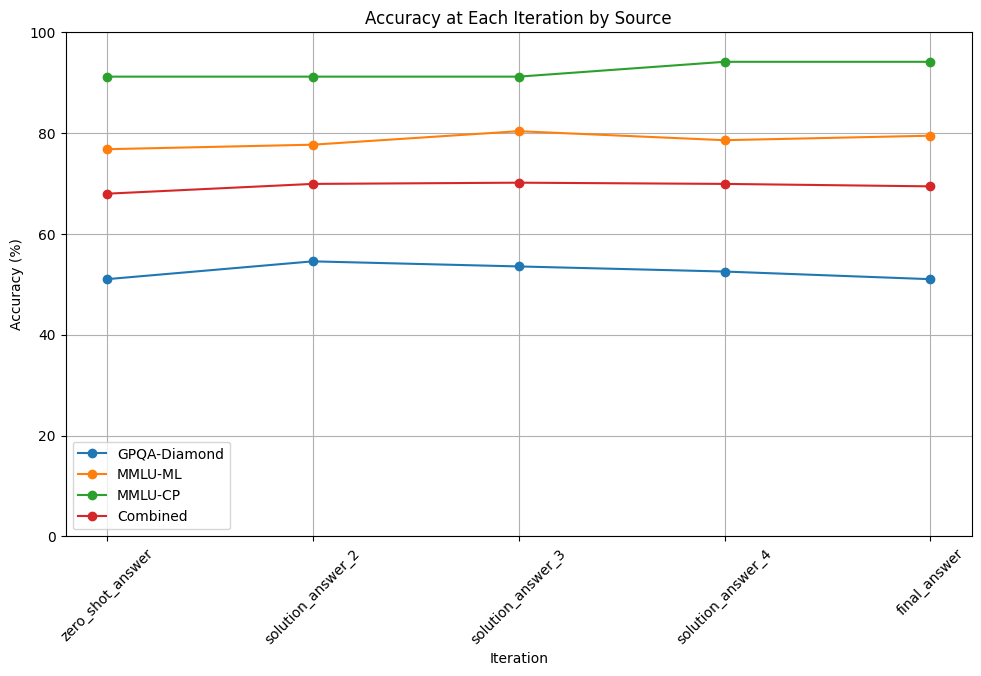

In [43]:
# Visualization
analyze_visual_iteration_data(raw_textgrad)

In [44]:
# Percentages
result = analyze_percentage_data(raw_textgrad)
result

{'GPQA-Diamond': {'zero_shot_result': np.float64(51.01),
  'final_result': np.float64(51.01),
  'majority_result': np.float64(58.59)},
 'MMLU-ML': {'zero_shot_result': np.float64(76.79),
  'final_result': np.float64(79.46),
  'majority_result': np.float64(83.93)},
 'MMLU-CP': {'zero_shot_result': np.float64(91.18),
  'final_result': np.float64(94.12),
  'majority_result': np.float64(97.06)},
 'Combined': {'zero_shot_result': np.float64(67.96),
  'final_result': np.float64(69.42),
  'majority_result': np.float64(75.0)}}

## 2. Analysis TextGrad with TextualVerifier

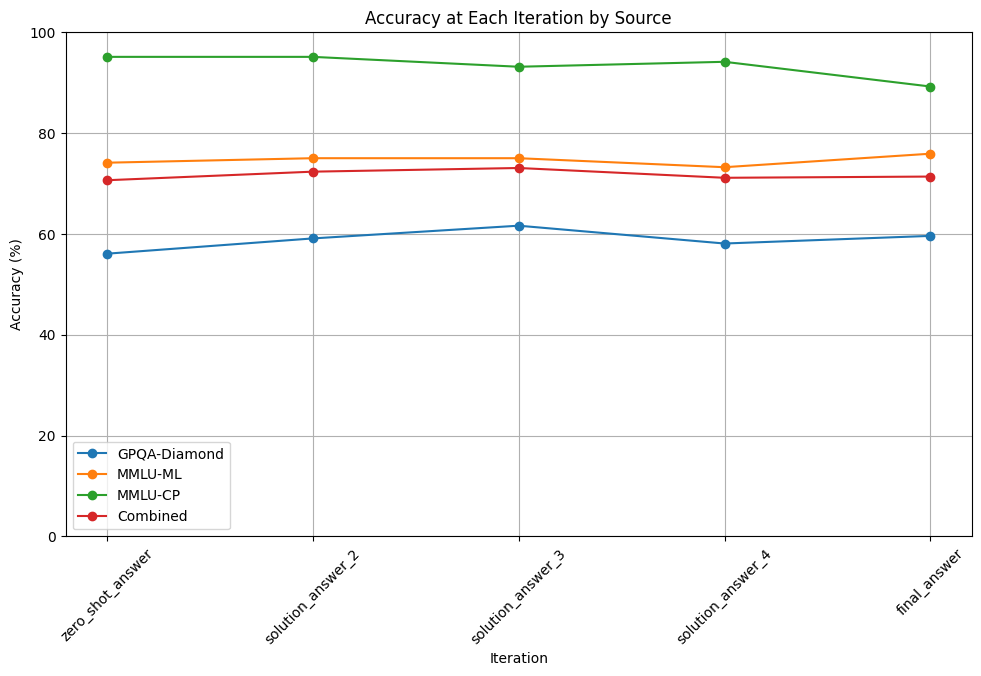

In [45]:
# Visualization
analyze_visual_iteration_data(tv_textgrad)

In [46]:
# Percentages
tv_result = analyze_percentage_data(tv_textgrad)
tv_result

{'GPQA-Diamond': {'zero_shot_result': np.float64(56.06),
  'final_result': np.float64(59.6),
  'majority_result': np.float64(61.11)},
 'MMLU-ML': {'zero_shot_result': np.float64(74.11),
  'final_result': np.float64(75.89),
  'majority_result': np.float64(78.57)},
 'MMLU-CP': {'zero_shot_result': np.float64(95.1),
  'final_result': np.float64(89.22),
  'majority_result': np.float64(94.12)},
 'Combined': {'zero_shot_result': np.float64(70.63),
  'final_result': np.float64(71.36),
  'majority_result': np.float64(74.03)}}

## 3. Analysis TextGrad with TextualVerifierV2

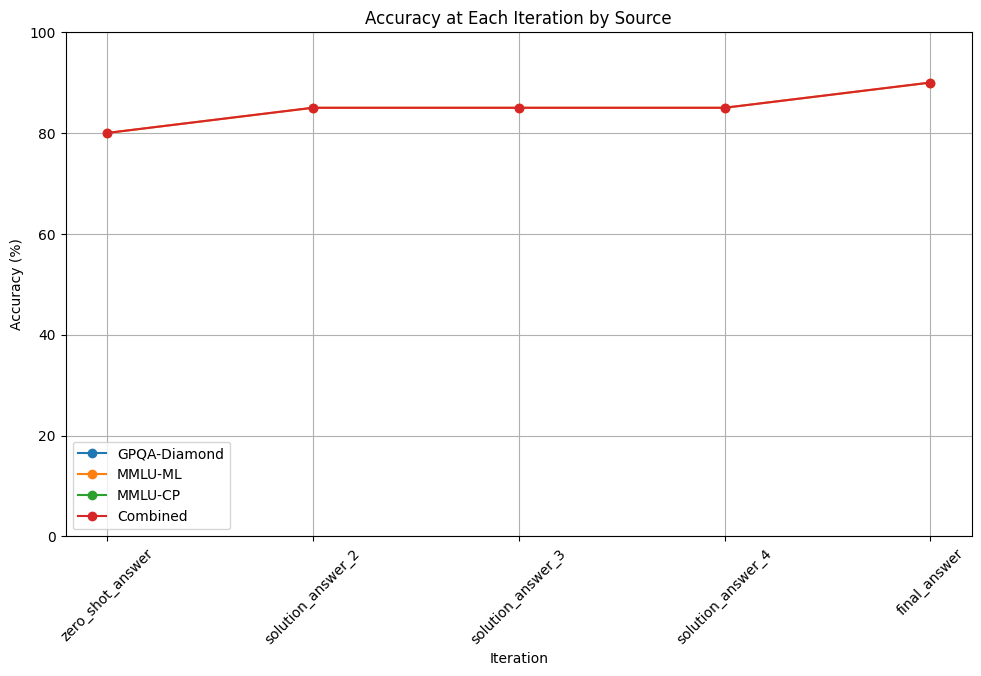

In [47]:
# Visualization
analyze_visual_iteration_data(tv2_textgrad)

In [48]:
# Percentages
tv2_result = analyze_percentage_data(tv2_textgrad)
tv2_result

{'GPQA-Diamond': {'zero_shot_result': None,
  'final_result': None,
  'majority_result': None},
 'MMLU-ML': {'zero_shot_result': np.float64(80.0),
  'final_result': np.float64(90.0),
  'majority_result': np.float64(85.0)},
 'MMLU-CP': {'zero_shot_result': None,
  'final_result': None,
  'majority_result': None},
 'Combined': {'zero_shot_result': np.float64(80.0),
  'final_result': np.float64(90.0),
  'majority_result': np.float64(85.0)}}